# Using DAE to perform denoising then send to classifier

### The most corrupted ECG signal(SNR=-6dB)

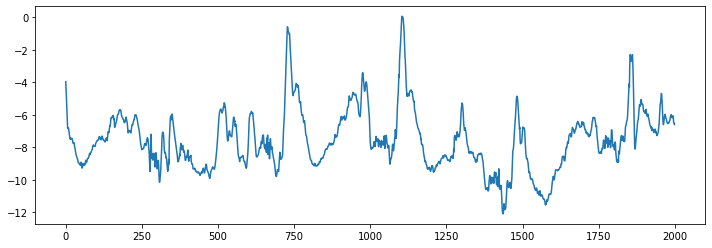

In [23]:
import sys
sys.path.append("../")
from models.ECG_classifier import Classifier
from models.DAE import AutoEncoder

import wfdb
import biosppy.signals.ecg as ecg
import numpy as np
import matplotlib.pyplot as plt

filename = '../../mit-bih-noise-stress-test-database-1.0.0/119e_6'
signal, fields = wfdb.rdsamp(filename)
annotation = wfdb.rdann(filename, 'atr')
MLII_raw = signal[:, 0]
plt.figure(figsize=(12, 4))
plt.plot(range(len(MLII_raw[110000:112000])), MLII_raw[110000:112000])

### After DAE denoising

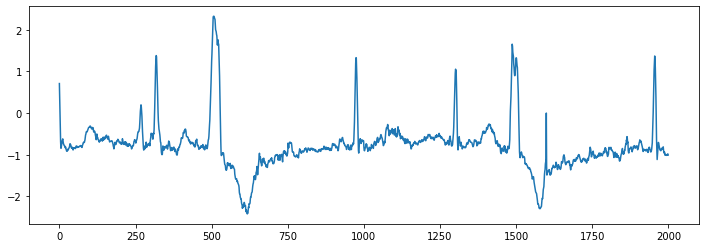

In [24]:
import torch
segments_10s = []
fs = fields['fs'] # sample rate
for i in range(0, len(MLII_raw), fs*10):
    if len(MLII_raw[i:i+fs*10]) == 3600:
        segments_10s.append(MLII_raw[i:i+fs*10])
segments_10s = torch.unsqueeze(torch.tensor(segments_10s), 1).float().cuda()
generator = AutoEncoder().cuda()
generator.load_state_dict(torch.load('../weights/DAE_param.pth'))
denoised_segments = generator(segments_10s).cpu().detach().numpy()
denoised = denoised_segments.reshape(-1)
plt.figure(figsize=(12, 4))
plt.plot(range(len(denoised[110000:112000])), denoised[110000:112000])

### Segmentation

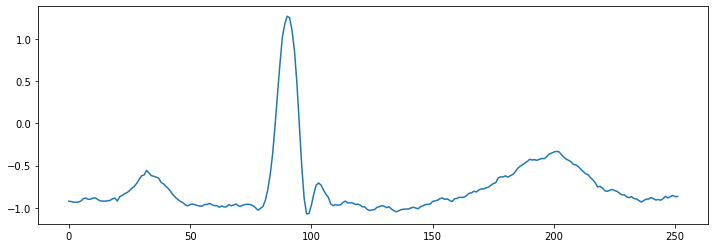

In [3]:
rpeaks, = ecg.hamilton_segmenter(signal=denoised, sampling_rate=fs)
rpeaks, = ecg.correct_rpeaks(
    signal=denoised,
    rpeaks=rpeaks,
    sampling_rate=fs,
    tol=0.05)
segments = []
for timestamp in rpeaks:
    if len(denoised[int(timestamp-0.25*fs):int(timestamp+0.45*fs)]) == 252:
        segments.append(denoised[int(timestamp-0.25*fs):int(timestamp+0.45*fs)])
plt.figure(figsize=(12, 4))
plt.plot(range(len(segments[0])), segments[0])

### Classification inference

In [4]:
encoding = 'NAVR'
model = Classifier().cuda()
model.load_state_dict(torch.load('../weights/ECG_classifier_params.pth'))
out = model(torch.unsqueeze(torch.tensor(segments).float().cuda(), 1))
_, pred = torch.max(out, 1)

label_pred = []
for i in pred:
    label_pred.append(encoding[i])

### Evaluate

In [5]:
def matrix(ts_pred, label_pred, ts, label, fs, tol=0.05):
    tol = tol * fs
    TP = 0
#     FP = 0
    matchIdx = []

    for i, r in enumerate(ts_pred):
        ti = np.argmin(np.abs(ts-r))
        t = ts[ti] # find closest timestamp in all of the ground truth
        error = np.abs(t-r)

        if error < tol:
            try:
                if label_pred[i] == label[ti]:
                    TP += 1
            except IndexError:
                pass # for the truncated segments
#         else:
#             if len(matchIdx) > 0:
#                 bdf = r - test[matchIdx[-1]]
#                 if bdf < minRR:
#                     # false positive, but removable with RR interval check
#                     pass
#                 else:
#                     FP += 1
#             else:
#                 FP += 1
    return {
        'performance': TP/len(ts)
    }

In [6]:
matrix(rpeaks, label_pred, annotation.sample, annotation.symbol, fs)['performance']

0.6260744985673352

## Perform on all of the dataset

In [7]:
fname_prefix = '../../mit-bih-noise-stress-test-database-1.0.0/'
flist = ['119e_6', '119e00', '119e06', '119e12', '119e18', '119e24']
perf_list = []
for f in flist:
    signal, fields = wfdb.rdsamp(fname_prefix+f)
    annotation = wfdb.rdann(fname_prefix+f, 'atr')
    MLII_raw = signal[:, 0]
    segments_10s = []
    fs = fields['fs']
    for i in range(0, len(MLII_raw), fs*10):
        if len(MLII_raw[i:i+fs*10]) == 3600:
            segments_10s.append(MLII_raw[i:i+fs*10])
    segments_10s = torch.unsqueeze(torch.tensor(segments_10s), 1).float().cuda()
    denoised = denoised_segments = generator(segments_10s).cpu().detach().numpy().reshape(-1)
    rpeaks, = ecg.hamilton_segmenter(signal=denoised, sampling_rate=fs)
    rpeaks, = ecg.correct_rpeaks(
        signal=denoised,
        rpeaks=rpeaks,
        sampling_rate=fs,
        tol=0.05)
    
    segments = []
    for timestamp in rpeaks:
        if len(denoised[int(timestamp-0.25*fs):int(timestamp+0.45*fs)]) == 252:
            segments.append(denoised[int(timestamp-0.25*fs):int(timestamp+0.45*fs)])
        
    out = model(torch.unsqueeze(torch.tensor(segments).float().cuda(), 1))
    _, pred = torch.max(out, 1)
    label_pred = []
    for i in pred:
        label_pred.append(encoding[i])
    perf = matrix(rpeaks, label_pred, annotation.sample, annotation.symbol, fs)['performance']
    print(f, perf)
    perf_list.append(perf)

119e_6 0.6356255969436485
119e00 0.6709646609360076
119e06 0.6829035339063992
119e12 0.6905444126074498
119e18 0.6824259789875836
119e24 0.6914995224450812


### Result

Dataset  | Performance
---------|------------
119e_6   | 0.63
119e00   | 0.67
119e06   | 0.68
119e12   | 0.69
119e18   | 0.68
119e24   | 0.69